In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load

In [3]:
def plot(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x, max_y))
    mask = np.ones((max_x, max_y))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

## DungeonGrams

In [15]:
config = DungeonGrams
graph = Utility.get_graph(config.BASE_DIR, config.TRANSPOSE, True)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


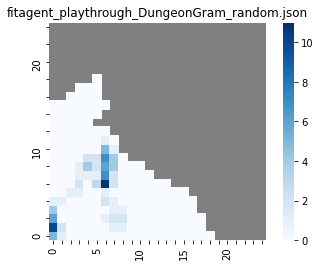

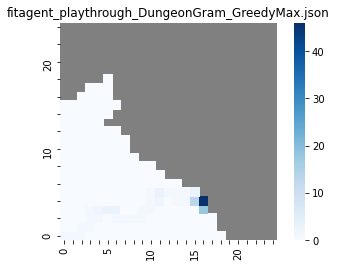

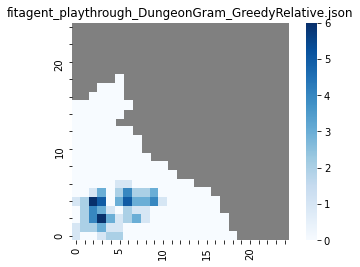

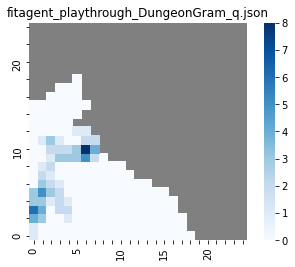

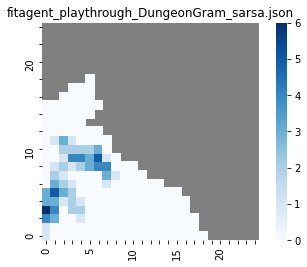

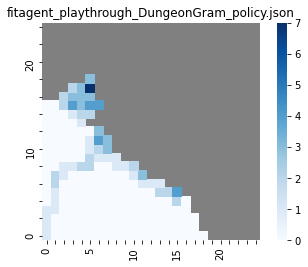

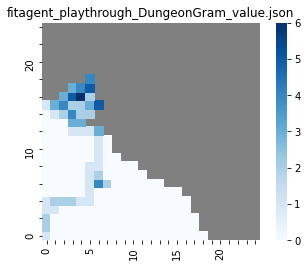

In [19]:
for filename in listdir(config.BASE_DIR):
    if 'fitagent_playthrough_' not in filename:
        continue
        
    with open(join(config.BASE_DIR, filename), 'r') as f:
        data = load(f)
        
    plot(data, graph, filename, (25,25))

### Mario

In [6]:
config = Mario
graph = Utility.get_graph(config.BASE_DIR, config.TRANSPOSE, True)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


In [13]:
for filename in listdir(config.BASE_DIR):
    if 'fitagent_playthrough_' not in filename:
        continue
        
    with open(join(config.BASE_DIR, filename), 'r') as f:
        data = load(f)
        
    plot(data, graph, filename, (25,25))

IndexError: index 37 is out of bounds for axis 0 with size 35

## Icarus

In [8]:
config = Icarus
graph = Utility.get_graph(config.BASE_DIR, config.TRANSPOSE, True)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


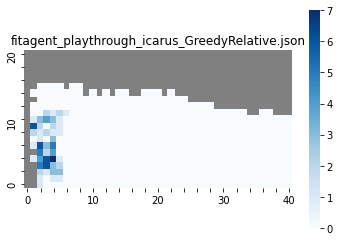

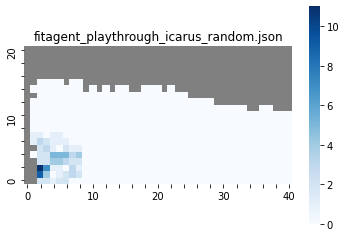

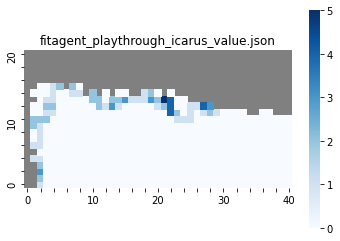

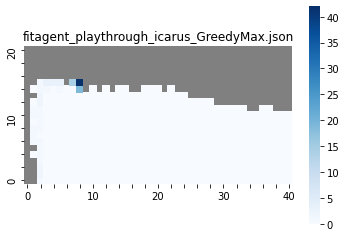

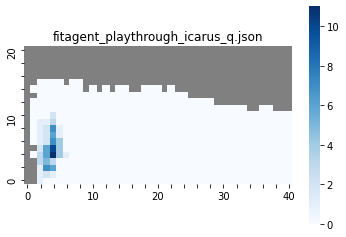

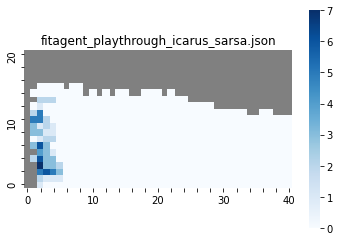

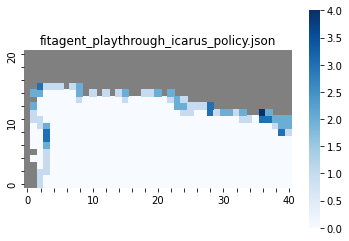

In [9]:
for filename in listdir(config.BASE_DIR):
    if 'fitagent_playthrough_' not in filename:
        continue
        
    with open(join(config.BASE_DIR, filename), 'r') as f:
        data = load(f)
        
    plot(data, graph, filename, (21, 41))